1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# Import for the whole program
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
file_name = "./Es5Files/data_000637.txt"
d = pd.read_csv(file_name)
N = 10000
df = pd.DataFrame(data=d, index=range(N))
print (df)


      HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0        1     0          123  3869200167        2374        26
1        1     0          124  3869200167        2374        27
2        1     0           63  3869200167        2553        28
3        1     0           64  3869200167        2558        19
4        1     0           64  3869200167        2760        25
...    ...   ...          ...         ...         ...       ...
9995     1     0           61  3869200267         696        11
9996     1     0           60  3869200267         701         5
9997     1     0           59  3869200267         707        23
9998     1     0           63  3869200267         706        15
9999     1     0           49  3869200267         777        13

[10000 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
#Find where the values changes
orbit_change = df["ORBIT_CNT"] != df["ORBIT_CNT"].shift(periods=-1)
#Compute the mean
df_mean = df[orbit_change].BX_COUNTER.mean()
print(df_mean)

#Observe that this mean could be verifed using:
#df_mean=df["BX_COUNTER"].mean()*2
#print(df_mean)

3046.6936936936936


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [4]:
# create a new pd substracting in the ORBIT_CNT collumn the first value of the collumn
orbit_change = df["ORBIT_CNT"] - df["ORBIT_CNT"].loc[0]
#Compute the absolute number of ns
df["Time"] = orbit_change*df_mean*25 + df["BX_COUNTER"]*25 + df["TDC_MEAS"]
# Assigment interpretation: Assume the data aquisition was started when we find first row,so aquisition started in 3869200167, 2374, 26
df["Time"] = df["Time"] - df["BX_COUNTER"].loc[0]*25 - df["TDC_MEAS"].loc[0]
#Convert to timeseries
df['Time'] = pd.to_datetime(df['Time'], unit='ns')
#Don't start from 1970, but find the absolute duration
#df['Time'] = df['Time'] - df['Time'].loc[0]
print(df)


      HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0        1     0          123  3869200167        2374        26   
1        1     0          124  3869200167        2374        27   
2        1     0           63  3869200167        2553        28   
3        1     0           64  3869200167        2558        19   
4        1     0           64  3869200167        2760        25   
...    ...   ...          ...         ...         ...       ...   
9995     1     0           61  3869200267         696        11   
9996     1     0           60  3869200267         701         5   
9997     1     0           59  3869200267         707        23   
9998     1     0           63  3869200267         706        15   
9999     1     0           49  3869200267         777        13   

                              Time  
0    1970-01-01 00:00:00.000000000  
1    1970-01-01 00:00:00.000000001  
2    1970-01-01 00:00:00.000004477  
3    1970-01-01 00:00:00.000004593  
4    1970-

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
df['Time'] = pd.to_datetime(df['Time']).dt.time
print(df)
# Now time is reported for the time collumn in hours, minutes and seconds, where seconds is a float reporting the milliseconds.

      HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0        1     0          123  3869200167        2374        26   
1        1     0          124  3869200167        2374        27   
2        1     0           63  3869200167        2553        28   
3        1     0           64  3869200167        2558        19   
4        1     0           64  3869200167        2760        25   
...    ...   ...          ...         ...         ...       ...   
9995     1     0           61  3869200267         696        11   
9996     1     0           60  3869200267         701         5   
9997     1     0           59  3869200267         707        23   
9998     1     0           63  3869200267         706        15   
9999     1     0           49  3869200267         777        13   

                 Time  
0            00:00:00  
1            00:00:00  
2     00:00:00.000004  
3     00:00:00.000004  
4     00:00:00.000009  
...               ...  
9995  00:00:00.007574  
999

5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
# Group by TDC_CHANNEL field
gk = df.groupby('TDC_CHANNEL')
# Sort by the size
gkSorted = gk.size().sort_values(ascending=False)

# Debug code:
#print( gk.size().sort_values(ascending=False))

#Print the first three values
first = gkSorted.head(3).index
print(first)

Int64Index([139, 63, 64], dtype='int64', name='TDC_CHANNEL')


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [7]:
print(df.loc[df["ORBIT_CNT"] == float("nan")])
orbit_change = df["ORBIT_CNT"] - df["ORBIT_CNT"].shift(periods=-1)
print(orbit_change.loc[orbit_change >= 2])
# There are no missing ORBIT_CNT, every ORBIT_CNT has the following one and no ORBIT_CNT has Nan values
n = abs(orbit_change.sum())
print(n)

Empty DataFrame
Columns: [HEAD, FPGA, TDC_CHANNEL, ORBIT_CNT, BX_COUNTER, TDC_MEAS, Time]
Index: []
Series([], Name: ORBIT_CNT, dtype: float64)
100.0


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:
# Count number of different ORBIT_CNT on TDC_CHANNEL=139
gk = df.loc[df["TDC_CHANNEL"]==139].groupby(['ORBIT_CNT'])
print(len(gk))


101


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [9]:
# select FPGA 0 or 1 and regroup by TDC_CHANNEL and print the size of the grop
g1 = df.loc[df["FPGA"] == 0].groupby(['TDC_CHANNEL']).size()
g2 = df.loc[df["FPGA"] == 1].groupby(['TDC_CHANNEL']).size()
print(g1)
print(g2)


TDC_CHANNEL
1        4
2       10
3        8
4       11
5       11
      ... 
121     45
122     55
123    138
124    130
139    599
Length: 117, dtype: int64
TDC_CHANNEL
1      237
2      250
3      193
4      200
5      128
      ... 
125      2
126      1
127     10
128     11
139    261
Length: 115, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

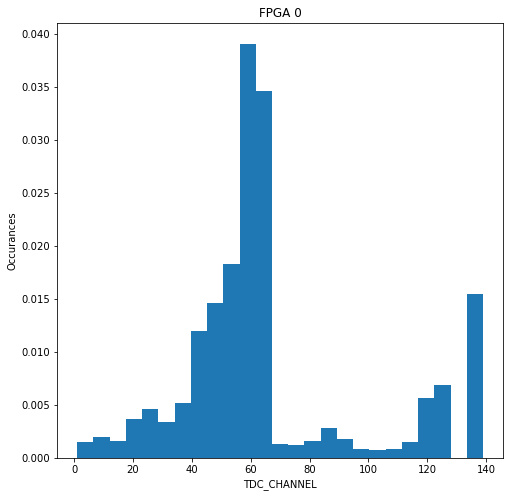

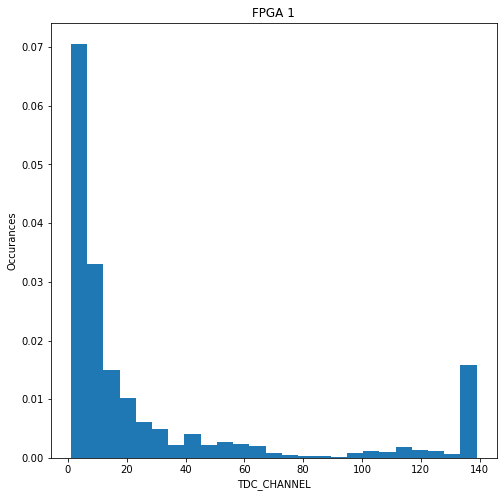

In [10]:
g1 = df.loc[df["FPGA"] == 0]
fig1 = plt.figure(num="Figure 1", figsize=(8, 8))
plt.hist(g1['TDC_CHANNEL'], bins=25, density=True, cumulative=False)
plt.title('FPGA 0')
plt.xlabel("TDC_CHANNEL")
plt.ylabel("Occurances")
plt.show()

g2 = df.loc[df["FPGA"] == 1]
fig2 = plt.figure(num="Figure 2", figsize=(8, 8))
plt.hist(g2['TDC_CHANNEL'], bins=25, density=True, cumulative=False)
plt.title('FPGA 1')
plt.xlabel("TDC_CHANNEL")
plt.ylabel("Occurances")
plt.show()